<a href="https://colab.research.google.com/github/alitheonly/PlantSeedling-/blob/main/0_5_Drop_Adam_All_B32_0214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

In [ ]:

# Import necessary libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
from glob import glob
import imageio

In [ ]:
!ls ../content/train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [ ]:
data_path = '/content/'
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

In [ ]:
images_path= '/content/train/*/*.png'
images = glob(images_path)

img_size = 128
train_images = []
train_labels = []
for i in images:
    train_images.append(cv2.resize(cv2.imread(i), (img_size, img_size))) 
    train_labels.append(i.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [ ]:
train_X

array([[[[ 53,  61,  77],
         [ 57,  65,  80],
         [ 62,  70,  84],
         ...,
         [ 38,  52,  89],
         [ 40,  54,  91],
         [ 41,  56,  93]],

        [[ 52,  60,  76],
         [ 56,  64,  79],
         [ 61,  69,  82],
         ...,
         [ 38,  51,  88],
         [ 38,  53,  89],
         [ 38,  53,  90]],

        [[ 52,  60,  75],
         [ 55,  63,  77],
         [ 59,  68,  81],
         ...,
         [ 38,  51,  85],
         [ 36,  50,  85],
         [ 34,  49,  85]],

        ...,

        [[ 86,  92, 101],
         [ 87,  93, 102],
         [ 89,  95, 103],
         ...,
         [ 80,  83,  84],
         [ 80,  83,  83],
         [ 80,  83,  83]],

        [[ 88,  92, 103],
         [ 87,  91, 101],
         [ 86,  89,  99],
         ...,
         [ 82,  85,  86],
         [ 82,  85,  85],
         [ 81,  85,  84]],

        [[ 89,  93, 104],
         [ 86,  90, 101],
         [ 83,  86,  96],
         ...,
         [ 84,  87,  88],
        

In [ ]:
train_Y

,0
0,Charlock
1,Charlock
2,Charlock
3,Charlock
4,Charlock
...,...
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent


In [ ]:
train_Y.rename(columns={0:'species'},inplace=True)
_, train_count = np.unique(train_Y,return_counts=True)
df = pd.DataFrame(data = train_count)
a = train_Y['species'].unique()
a = a.tolist()
a.sort()
df['Index'] = a
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


In [ ]:
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(train_Y.species)
train_label = np.array(y,dtype=np.float32)
train_label

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X, train_label,test_size=0.3,random_state=7)
print((X_train.shape,X_test.shape))

((3800, 224, 224, 3), (950, 224, 224, 3))



**Image** Normalization




In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

## Image Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

VGG Model

In [ ]:

from keras.applications.vgg16 import VGG16

# Instantiate a VGG16 model with pre-trained weights

base_model= VGG16(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
base_model.trainable = False



In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
#Saving the best model using model checkpoint callback
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = tf.keras.callbacks.ModelCheckpoint('Split Sklearn Train/Valid VGG16.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

58.25102233886719 MB


In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))#,callbacks = [early_stopping,checkpoint])

Epoch 1/25
119/119 [==============================] - 151s 1s/step - loss: 2.1520 - accuracy: 0.2618 - val_loss: 1.9137 - val_accuracy: 0.3621
Epoch 2/25
119/119 [==============================] - 149s 1s/step - loss: 1.7768 - accuracy: 0.4018 - val_loss: 1.7173 - val_accuracy: 0.4295
Epoch 3/25
119/119 [==============================] - 149s 1s/step - loss: 1.6188 - accuracy: 0.4521 - val_loss: 1.5487 - val_accuracy: 0.4937
Epoch 4/25
119/119 [==============================] - 148s 1s/step - loss: 1.5133 - accuracy: 0.4855 - val_loss: 1.4336 - val_accuracy: 0.5495
Epoch 5/25
119/119 [==============================] - 150s 1s/step - loss: 1.4154 - accuracy: 0.5195 - val_loss: 1.3916 - val_accuracy: 0.5421
Epoch 6/25
119/119 [==============================] - 151s 1s/step - loss: 1.3487 - accuracy: 0.5368 - val_loss: 1.3040 - val_accuracy: 0.5632
Epoch 7/25
119/119 [==============================] - 150s 1s/step - loss: 1.2963 - accuracy: 0.5468 - val_loss: 1.2432 - val_accuracy: 0.5684

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

62.37035369873047 MB


In [ ]:
#from google.colab import files
# model.save('Split Sklearn Train/Valid VGG16.h5')
#files.download('Split Sklearn Train/Valid VGG16.h5')

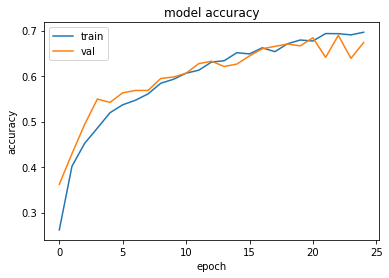

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

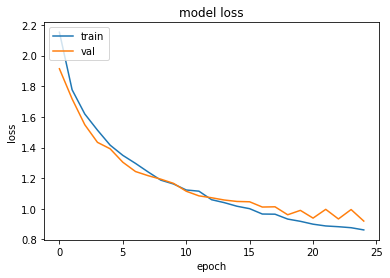

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)

119/119 [==============================] - 130s 1s/step - loss: 0.7552 - accuracy: 0.7492
Test loss: 0.9199341535568237    Test accuracy: 0.6736842393875122
Train loss: 0.7552250027656555    Train accuracy: 0.74921053647995


## Resnet 50

In [ ]:
from keras.applications import ResNet152V2
# Instantiate a ResNet50 model with pre-trained weights
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

234545216/234545216 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_13[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_13[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

232.04363250732422 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
119/119 [==============================] - 154s 1s/step - loss: 1.1401 - accuracy: 0.6255 - val_loss: 0.7440 - val_accuracy: 0.7526
Epoch 2/25
119/119 [==============================] - 143s 1s/step - loss: 0.5574 - accuracy: 0.8076 - val_loss: 0.6013 - val_accuracy: 0.7916
Epoch 3/25
119/119 [==============================] - 141s 1s/step - loss: 0.4139 - accuracy: 0.8521 - val_loss: 0.5871 - val_accuracy: 0.8021
Epoch 4/25
119/119 [==============================] - 143s 1s/step - loss: 0.3449 - accuracy: 0.8797 - val_loss: 0.5481 - val_accuracy: 0.8084
Epoch 5/25
119/119 [==============================] - 143s 1s/step - loss: 0.2794 - accuracy: 0.9003 - val_loss: 0.4943 - val_accuracy: 0.8400
Epoch 6/25
119/119 [==============================] - 144s 1s/step - loss: 0.2258 - accuracy: 0.9200 - val_loss: 0.5244 - val_accuracy: 0.8295
Epoch 7/25
119/119 [==============================] - 144s 1s/step - loss: 0.1923 - accuracy: 0.9329 - val_loss: 0.5085 - val_accuracy: 0.8432

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

248.15567779541016 MB


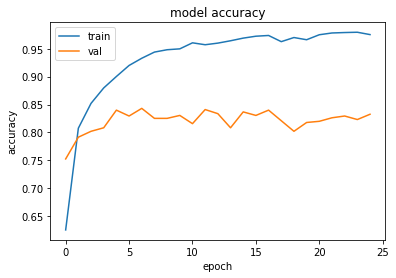

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


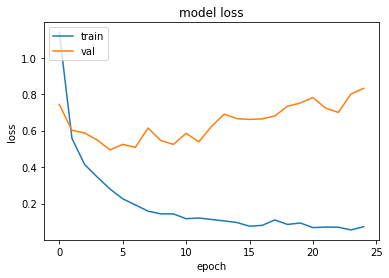

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


119/119 [==============================] - 114s 953ms/step - loss: 0.0120 - accuracy: 0.9976
Test loss: 0.8323427438735962    Test accuracy: 0.8326315879821777
Train loss: 0.011954336427152157    Train accuracy: 0.9976315498352051


## INCEPTION V3

In [ ]:
from keras.applications import InceptionV3
# Instantiate a InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")


92.06034088134766 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
119/119 [==============================] - 38s 291ms/step - loss: 1.4333 - accuracy: 0.5529 - val_loss: 1.0068 - val_accuracy: 0.6642
Epoch 2/25
119/119 [==============================] - 32s 268ms/step - loss: 0.8379 - accuracy: 0.7047 - val_loss: 0.7843 - val_accuracy: 0.7337
Epoch 3/25
119/119 [==============================] - 32s 272ms/step - loss: 0.6841 - accuracy: 0.7571 - val_loss: 0.6891 - val_accuracy: 0.7600
Epoch 4/25
119/119 [==============================] - 32s 269ms/step - loss: 0.5581 - accuracy: 0.8071 - val_loss: 0.6775 - val_accuracy: 0.7632
Epoch 5/25
119/119 [==============================] - 32s 270ms/step - loss: 0.5247 - accuracy: 0.8050 - val_loss: 0.6847 - val_accuracy: 0.7663
Epoch 6/25
119/119 [==============================] - 32s 271ms/step - loss: 0.4557 - accuracy: 0.8392 - val_loss: 0.6196 - val_accuracy: 0.7916
Epoch 7/25
119/119 [==============================] - 34s 288ms/step - loss: 0.4178 - accuracy: 0.8537 - val_loss: 0.6314 - val_ac

In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")



108.17231750488281 MB


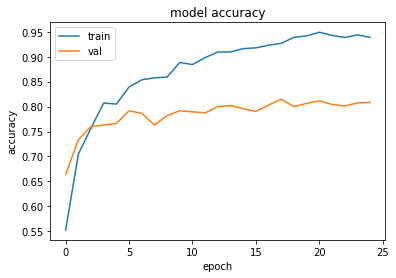

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


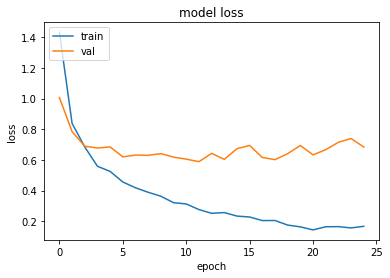

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


119/119 [==============================] - 26s 216ms/step - loss: 0.0421 - accuracy: 0.9908
Test loss: 0.6840679049491882    Test accuracy: 0.8084210753440857
Train loss: 0.042082104831933975    Train accuracy: 0.9907894730567932


## XCEPTION

In [ ]:
from keras.applications import Xception
# Instantiate a Xception model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")


88.02408599853516 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
119/119 [==============================] - 76s 622ms/step - loss: 1.2506 - accuracy: 0.5874 - val_loss: 0.9006 - val_accuracy: 0.6979
Epoch 2/25
119/119 [==============================] - 72s 605ms/step - loss: 0.7558 - accuracy: 0.7355 - val_loss: 0.7458 - val_accuracy: 0.7600
Epoch 3/25
119/119 [==============================] - 69s 582ms/step - loss: 0.5812 - accuracy: 0.7995 - val_loss: 0.7341 - val_accuracy: 0.7600
Epoch 4/25
119/119 [==============================] - 70s 592ms/step - loss: 0.4753 - accuracy: 0.8337 - val_loss: 0.6632 - val_accuracy: 0.7779
Epoch 5/25
119/119 [==============================] - 71s 596ms/step - loss: 0.4074 - accuracy: 0.8624 - val_loss: 0.6586 - val_accuracy: 0.7800
Epoch 6/25
119/119 [==============================] - 73s 618ms/step - loss: 0.3568 - accuracy: 0.8739 - val_loss: 0.6557 - val_accuracy: 0.7842
Epoch 7/25
119/119 [==============================] - 71s 595ms/step - loss: 0.3038 - accuracy: 0.8924 - val_loss: 0.6649 - val_ac

In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")



104.13622283935547 MB


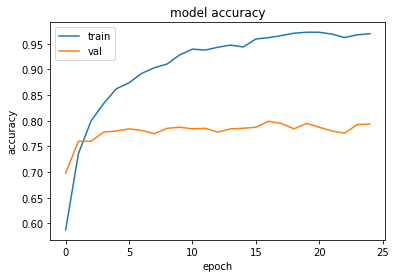

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


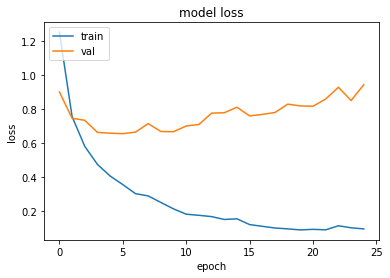

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


119/119 [==============================] - 59s 493ms/step - loss: 0.0268 - accuracy: 0.9958
Test loss: 0.9429562091827393    Test accuracy: 0.793684184551239
Train loss: 0.026775840669870377    Train accuracy: 0.9957894682884216


## **DenseNet121**

In [ ]:
from keras.applications import DenseNet121
# Instantiate a DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_16[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_16[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")


32.02589416503906 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
119/119 [==============================] - 87s 675ms/step - loss: 1.3813 - accuracy: 0.5442 - val_loss: 0.9235 - val_accuracy: 0.6947
Epoch 2/25
119/119 [==============================] - 81s 681ms/step - loss: 0.7666 - accuracy: 0.7353 - val_loss: 0.6651 - val_accuracy: 0.7800
Epoch 3/25
119/119 [==============================] - 76s 640ms/step - loss: 0.6043 - accuracy: 0.7942 - val_loss: 0.6687 - val_accuracy: 0.7821
Epoch 4/25
119/119 [==============================] - 80s 677ms/step - loss: 0.5218 - accuracy: 0.8184 - val_loss: 0.6299 - val_accuracy: 0.7895
Epoch 5/25
119/119 [==============================] - 77s 648ms/step - loss: 0.4537 - accuracy: 0.8392 - val_loss: 0.5659 - val_accuracy: 0.8158
Epoch 6/25
119/119 [==============================] - 79s 666ms/step - loss: 0.4249 - accuracy: 0.8526 - val_loss: 0.5668 - val_accuracy: 0.8105
Epoch 7/25
119/119 [==============================] - 78s 655ms/step - loss: 0.3748 - accuracy: 0.8689 - val_loss: 0.5133 - val_ac

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



40.13800811767578 MB


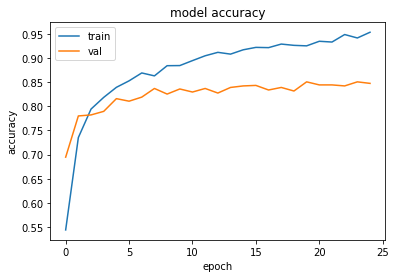

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


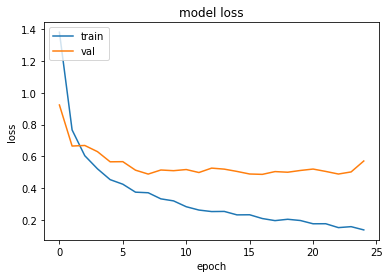

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


119/119 [==============================] - 58s 489ms/step - loss: 0.0731 - accuracy: 0.9816
Test loss: 0.5710196495056152    Test accuracy: 0.8473684191703796
Train loss: 0.07306206226348877    Train accuracy: 0.9815789461135864


### MobileNetV2

In [ ]:
from keras.applications import MobileNetV2
# Instantiate a DenseNet121 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('MobileNetV2_0129.h5')


print(os.path.getsize("MobileNetV2_0129.h5")/1048576, "MB")


14.125579833984375 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
119/119 [==============================] - 30s 232ms/step - loss: 1.2608 - accuracy: 0.5916 - val_loss: 0.7485 - val_accuracy: 0.7400
Epoch 2/25
119/119 [==============================] - 31s 257ms/step - loss: 0.6841 - accuracy: 0.7616 - val_loss: 0.6303 - val_accuracy: 0.7705
Epoch 3/25
119/119 [==============================] - 31s 257ms/step - loss: 0.5387 - accuracy: 0.8192 - val_loss: 0.5237 - val_accuracy: 0.8232
Epoch 4/25
119/119 [==============================] - 30s 249ms/step - loss: 0.4564 - accuracy: 0.8411 - val_loss: 0.4993 - val_accuracy: 0.8232
Epoch 5/25
119/119 [==============================] - 30s 249ms/step - loss: 0.4151 - accuracy: 0.8534 - val_loss: 0.5666 - val_accuracy: 0.8021
Epoch 6/25
119/119 [==============================] - 30s 249ms/step - loss: 0.3890 - accuracy: 0.8555 - val_loss: 0.5334 - val_accuracy: 0.8242
Epoch 7/25
119/119 [==============================] - 25s 210ms/step - loss: 0.3224 - accuracy: 0.8866 - val_loss: 0.5207 - val_ac

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



24.23773193359375 MB


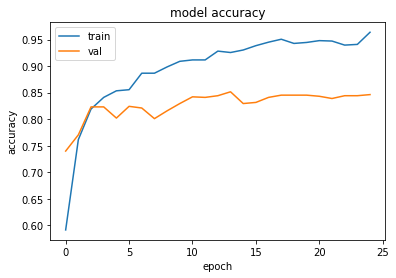

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


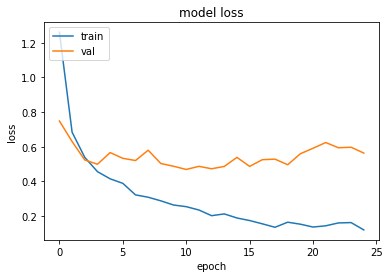

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


119/119 [==============================] - 20s 163ms/step - loss: 0.0447 - accuracy: 0.9876
Test loss: 0.5636135339736938    Test accuracy: 0.8463158011436462
Train loss: 0.0447482131421566    Train accuracy: 0.9876315593719482


## **Predict train model**

In [ ]:
predictions = model.predict(X_test)

30/30 [==============================] - 18s 560ms/step


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% \n({})".format(np.array(df.Name)[predicted_label],
                                100*np.max(predictions_array),
                                np.array(df.Name)[true_label]),
                                color=color)

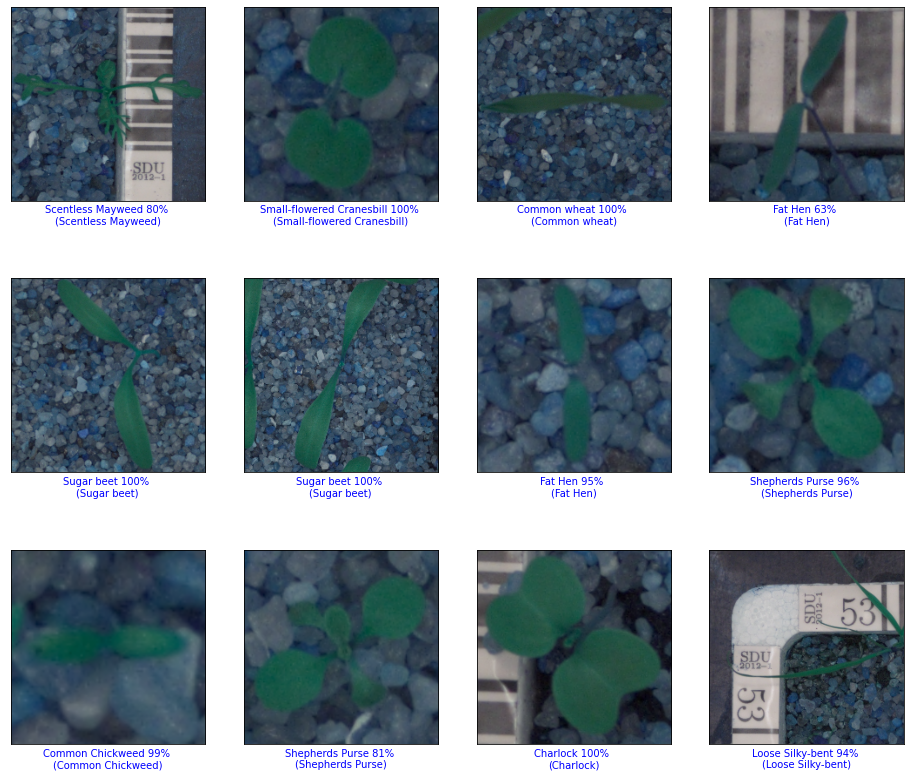

In [ ]:
fig=plt.figure(figsize=(16, 20))
rows, cols = 3,4
for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplots_adjust(hspace=-0.5)
plt.show()